In [1]:
import os
import torch
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import time, datetime
import copy
import numpy as np
from torch.optim import lr_scheduler
from torchvision import datasets
from resnet_pytorch import ResNet 
import random
from PIL import Image
from torch.nn import functional as F

# 필요한 패키지와 라이브러리를 가져옴
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


# 그래프를 노트북 안에 그리기 위해 설정
%matplotlib inline

# 한글 폰트
font_name = fm.FontProperties(fname="/usr/share/fonts/nanum/NanumGothicExtraBold.ttf").get_name()
plt.rc('font', family=font_name)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### input param. 지정

In [2]:
batch_size = 32
input_path = "/home/piai/Documents/Hanja_crop/"
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [3]:
## test data transform & load
test_transform = transforms.Compose([
                                        transforms.Resize((224,224)),
                                        transforms.ToTensor(),
                                        normalize
                                    ])
test_dataset = datasets.ImageFolder(input_path + 'test', test_transform)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

In [4]:
## class 지정
classes = test_dataset.classes
len(classes)

4893

### 학습 model load

In [5]:
model = ResNet.from_pretrained("resnet101", num_classes=len(classes))
model.to(device)

model.load_state_dict(torch.load('./models/runs/exp1/best_weights.pth'))

Loaded pretrained weights for resnet101.


<All keys matched successfully>

## Test the Model

In [6]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += torch.sum(predicted == labels.data)
        #print(labels)
        #print(predicted)
        # correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

/home/piai/anaconda3/envs/posco14/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Accuracy of the model on the test images: 94.9151840209961 %


### 일부 test 이미지 확인

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


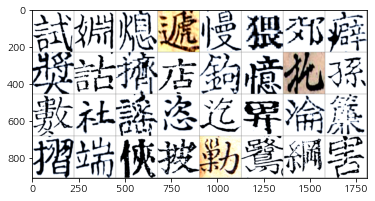

True:       631   478   446  2537  3327  3503  3566  3981  3569  4437  1614  1633  4599  3014  1470   525  1266  2527  3898  2768   628  3992  1918  4286  2913  2270  4234  1676  2417   595  1104  1236
Predict:    631   478   446  2537  3327  3503  3566  3981  3569  4437  1614  1633  4599  3014  1470   525  1266  2527  2200  2768   628  3992  1918  4286  2913  2270  4234  1676  2417   595  1104  1236


In [7]:
import torchvision

## 
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


## test 이미지를 무작위로 가져오기
dataiter = iter(test_loader)
images, labels = dataiter.next()

## 학습된 모델 이용하여 test 이미지 예측
outputs = model(images.to(device))
predicted = torch.max(outputs.data, 1)[1].cpu()

## test 이미지와 실제 label/예측 label 찍기
imshow(torchvision.utils.make_grid(images))
print('True:    ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))
print('Predict: ', ' '.join('%5s' % classes[predicted[j]] for j in range(batch_size)))

### test 이미지 30개 랜덤추출하여 실제 label/예측 label 보여주기

In [9]:
## 학습 model과 test loader를 입력받아 각 image와 실제 label/예측 확률 return

def get_predictions(model, iterator):
    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [10]:
## image normalize
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [11]:
images, labels, probs = get_predictions(model, test_loader)
pred_labels = torch.argmax(probs, 1) ## 이미지 별 예측 확률 중 가장 높은 확률의 라벨 추출

In [12]:
## images에서 30개 이미지 index 랜덤 추출
img_list = random.sample(range(len(images)), 30)
img_list[:5]

[23098, 8417, 9375, 13715, 11463]

In [14]:
fig, axs = plt.subplots(len(img_list), 2, figsize=(15, 40))

j = 0

## 30개 image index로 실제 라벨과 예측 라벨/확률 찾고 이미지 보이기
for idx in img_list:
    ax1 = axs[j, 0] ## 실제 이미지 위치 지정
    ax2 = axs[j, 1] ## 예측 이미지 위치 지정

    
    true_label = classes[labels[idx]] ## 실제 라벨
    pred_prob, pred_label = max(probs[idx]), classes[pred_labels[idx]] ## 예측 라벨
    
    ## 실제 이미지 load
    img1 = images[idx].permute(1, 2, 0)
    if normalize:
        img1 = normalize_image(img1)
        
    ## 예측 이미지 load: img_path2 + 예측 라벨의 폴더 내 1번째 이미지 load
    img_path2 = '/home/piai/Documents/Hanja_crop/train/{}/'.format(pred_label)
    img_name2 = img_path2 + os.listdir(img_path2)[0]
    img2 = Image.open(img_name2).convert('RGB')
    img2  = np.array(img2)

    ax1.imshow(img1)
    ax1.set_title(f'true label: {true_label}')
    
    ax2.imshow(img2)
    ax2.set_title(f'pred label: {pred_label} ({pred_prob*100:.2f})')
    
    
    ax1.axis('off')
    ax2.axis('off')
    j+=1